In [491]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [492]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-07.csv'

print(today_date_str)

_2024-03-12.csv


In [493]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1387 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3005759903308,USD,404.52,USD,406.55,USD,1.48,USD,0.365866,0.501829,7318827360.76,16120400,16120752,72209,19748965.3,22919527.86666667,24630333.25555556,1.236106,2.122994,1.420624,403.820000,36.58596145,Technology Services,0.52487446,1.0122284,1.0291758,0.8906199,4.635922,5.449480,4.056340,2.388470,1.012997,0.530606,0.52271728,0.8159635,0.14734287,0.25889797,420.74,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,404.78,USD,405.1300,USD,405.3100,USD,405.3100,USD,405.3100,USD,405.68,USD,405.680,USD,405.680,USD,417.35,USD,958891.40271493,USD,404.53400,404.507500,404.68000,404.899285,405.212945,404.689480,404.166015,405.458530,404.907255,404.355980
1,AAPL,Apple Inc.,NASDAQ,2667584918457.0005,USD,172.75,USD,173.50,USD,0.45,USD,0.260492,0.434153,15427955964.3,60139092,60139473,461619,76691599.59999931,61571504.96666716,56488342.83333315,2.121476,2.001895,1.530481,173.060000,26.87879259,Electronic Technology,0.51848065,1.1943091,1.2041771,1.2891104,4.187274,4.701171,3.556324,2.291255,0.795674,0.409137,0.49666564,0.80438104,0.21356141,0.44222268,188.67,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,172.86,USD,173.0699,USD,173.0699,USD,173.0699,USD,173.0699,USD,173.42,USD,174.380,USD,174.380,USD,180.53,USD,2380652.17391304,USD,172.75200,172.695638,172.74900,172.728708,173.035136,172.769865,172.504594,172.954272,172.711560,172.468848
2,NVDA,NVIDIA Corporation,NASDAQ,2144349975585.9995,USD,857.74,USD,873.20,USD,17.41,USD,2.029753,1.802411,2400917500,67835182,67836412,1102499,59186350.6,56392309.39999998,47211413.3777779,5.502222,6.353652,4.166541,862.456667,71.85858501,Electronic Technology,0.67736124,1.8691602,2.3419523,1.7245569,3.018525,1.746477,1.823664,1.289879,0.483764,0.244373,0.48087297,1.18092199,0.27428133,0.45972627,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,859.49,USD,861.3800,USD,861.3800,USD,861.3800,USD,861.3800,USD,868.87,USD,887.970,USD,887.970,USD,974.00,USD,2058175.67567568,USD,856.97888,856.430550,856.98000,858.401631,860.832024,857.560265,854.288506,868.189750,860.445505,852.701260
3,AMZN,"Amazon.com, Inc.",NASDAQ,1786214082318,USD,171.96,USD,173.00,USD,1.34,USD,0.7792

In [494]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [495]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.005760e+12,USD,404.52,USD,406.55,USD,1.48,USD,0.365866,0.501829,7318827360.76,16120400,16120752,72209,19748965.3,22919527.86666667,24630333.25555556,1.236106,2.122994,1.420624,403.820000,36.58596145,Technology Services,0.52487446,1.0122284,1.0291758,0.8906199,4.635922,5.449480,4.056340,2.388470,1.012997,0.530606,0.52271728,0.8159635,0.14734287,0.25889797,420.74,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,404.78,USD,405.1300,USD,405.3100,USD,405.3100,USD,405.3100,USD,405.68,USD,405.680,USD,405.680,USD,417.35,USD,958891.40271493,USD,404.53400,404.507500,404.68000,404.899285,405.212945,404.689480,404.166015,405.458530,404.907255,404.355980,Titans
1,AAPL,Apple Inc.,NASDAQ,2.667585e+12,USD,172.75,USD,173.50,USD,0.45,USD,0.260492,0.434153,15427955964.3,60139092,60139473,461619,76691599.59999931,61571504.96666716,56488342.83333315,2.121476,2.001895,1.530481,173.060000,26.87879259,Electronic Technology,0.51848065,1.1943091,1.2041771,1.2891104,4.187274,4.701171,3.556324,2.291255,0.795674,0.409137,0.49666564,0.80438104,0.21356141,0.44222268,188.67,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,172.86,USD,173.0699,USD,173.0699,USD,173.0699,USD,173.0699,USD,173.42,USD,174.380,USD,174.380,USD,180.53,USD,2380652.17391304,USD,172.75200,172.695638,172.74900,172.728708,173.035136,172.769865,172.504594,172.954272,172.711560,172.468848,Titans
2,NVDA,NVIDIA Corporation,NASDAQ,2.144350e+12,USD,857.74,USD,873.20,USD,17.41,USD,2.029753,1.802411,2400917500,67835182,67836412,1102499,59186350.6,56392309.39999998,47211413.3777779,5.502222,6.353652,4.166541,862.456667,71.85858501,Electronic Technology,0.67736124,1.8691602,2.3419523,1.7245569,3.018525,1.746477,1.823664,1.289879,0.483764,0.244373,0.48087297,1.18092199,0.27428133,0.45972627,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,859.49,USD,861.3800,USD,861.3800,USD,861.3800,USD,861.3800,USD,868.87,USD,887.970,USD,887.970,USD,974.00,USD,2058175.67567568,USD,856.97888,856.430550,856.98000,858.401631,860.832024,857.560265,854.288506,868.189750,860.445505,852.701260,Titans
3,AMZN,"Amazon.com, Inc.",NASDAQ,1.786214e+12,USD,171.96,USD,173.0

In [496]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [497]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1387 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,319,22.999279
1,Large caps,294,21.196828
2,Midlers,267,19.250180
3,Shrimp,231,16.654650
4,Micro caps,229,16.510454
5,Titans,35,2.523432
6,Undefined,12,0.865177


In [498]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1375 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
947,CGEN,Compugen Ltd.,NASDAQ,2.488939e+08,USD,2.7800,USD,2.780,USD,0.0400,USD,1.438849,0.000000,84651430.81140001,758279,758279,1911,1287810.5,810661.76666667,2085060.1,9.386282,13.350855,8.092037,2.860000,-,Health Technology,0.37509532,1.8168621,3.0044155,2.6499116,1.659822,3.412867,3.174690,2.009695,0.596496,0.258656,0.2917582,0.59639718,0.19473659,0.44045529,3.0301,USD,3.0301,USD,3.0301,USD,3.0301,USD,19.90,USD,2.7975,USD,2.80000,USD,2.80000,USD,2.80000,USD,2.80000,USD,2.93,USD,3.0300,USD,3.0300,USD,3.0301,USD,492044.11764732,USD,2.786500,2.784687,2.782020,2.799615,2.796905,2.783195,2.769485,2.878304,2.817530,2.756756,Micro caps
996,EM,Smart Share Global Limited,NASDAQ,1.786776e+08,USD,0.6877,USD,0.700,USD,0.0456,USD,6.630798,1.788571,213066905.455363,975942,975942,1100,305186.9,200394,95588.62222222,18.181818,17.133216,11.744422,0.692567,-,Finance,2.40090464,0.6811072,0.4771536,0.4771536,10.399493,4.988828,0.882656,0.205529,0.130227,0.116848,0.83305818,3.95143175,1.67670603,2.43911707,0.7500,USD,0.7500,USD,0.8782,USD,1.3300,USD,10.00,USD,0.6895,USD,0.69050,USD,0.69125,USD,0.69125,USD,0.69125,USD,0.70,USD,0.7300,USD,0.7300,USD,0.7500,USD,115287.07343628,USD,0.688220,0.687325,0.687520,0.689127,0.696294,0.688882,0.681471,0.702402,0.689043,0.675683,Micro caps
1242,KPRX,"Kiora Pharmaceuticals, Inc.",NASDAQ,1.659170e+07,USD,0.6410,USD,0.663,USD,0.0220,USD,3.432137,3.432137,7331828.74632,173560,173560,100,247062.1,3294083.96666667,1161490.28888889,9.629032,8.815295,9.282923,0.646900,-,Health Technology,0.50611362,-0.23937279,-1.2195315,-0.28571472,0.084495,0.141386,0.159096,0.280665,0.143933,0.076900,0.66601658,0.51198728,0.01745637,0.12180327,0.7500,USD,0.9980,USD,0.9980,USD,5.2500,USD,21000.00,USD,0.6538,USD,0.65505,USD,0.65780,USD,0.65780,USD,0.65780,USD,0.67,USD,0.6797,USD,0.6797,USD,0.7001,USD,0,USD,0.651175,0.652390,0.653065,0.655283,0.671163,0.655814,0.640464,0.676772,0.656974,0.637176,Shrimp
1122,GRYP,"Gryphon Digital Mining, Inc",NASDAQ,6.081168e+07,USD,1.5700,USD,1.600,USD,0.0200,USD,1.273885,1.910828,31801718.7432,3535718,3535718,34315,725659.7,444291.745,157973.75944444,72.666667,26.981156,28.234655,1.886667,-,

In [499]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

market_cap_type_df2
print(market_cap_type_df2)


  marketCapType  count  percentage
0    Small caps    319   23.200000
1    Large caps    294   21.381818
2       Midlers    267   19.418182
3        Shrimp    231   16.800000
4    Micro caps    229   16.654545
5        Titans     35    2.545455


In [500]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [501]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1375
Number of rows removed: 1363
NEW DataFrame length: 12


In [502]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,4,33.333333
1,Small caps,3,25.000000
2,Midlers,2,16.666667
3,Titans,1,8.333333
4,Micro caps,1,8.333333
5,Shrimp,1,8.333333


In [503]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps' 'Shrimp']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relat

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,LIN,Linde plc,NASDAQ,2.260905e+11,USD,469.48,USD,471.00,USD,1.5200,USD,0.323762,0.323762,4.732746e+08,4251520,4251545,1310,2621842,2025099.83333333,1790977.56666667,2.448848,1.623860,1.232955,470.070000,37.2697828,Process Industries,1.734477,0.8901112,0.9511786,0.9398538,1.615437,3.572644,4.384905,3.288702,1.842960,1.309160,1.72508517,1.828384,0.51797606,0.62835673,473.9800,USD,473.980000,USD,473.980000,USD,473.980000,USD,473.980000,USD,469.9100,USD,470.72,USD,471.09,USD,471.09,USD,471.09,USD,472.160,USD,473.9800,USD,473.9800,USD,473.9800,USD,495363.59935467,USD,469.58400,469.656250,470.07798,470.527492,470.764881,469.978995,469.193109,471.495873,470.276870,469.057867,Titans
1,GRMN,Garmin Ltd.,NYSE,2.799759e+10,USD,145.99,USD,146.08,USD,4.0100,USD,2.746763,0.061648,1.540008e+08,2714492,2714492,202,1319652.2,1099298.2,895180.67777778,3.580508,2.208538,1.937147,144.753333,21.74606012,Electronic Technology,1.906853,1.3129826,0.98954487,0.9843969,3.341554,3.473364,2.682649,3.560383,2.725977,2.178230,4.35869173,2.293724,0.62357593,0.53723553,146.6700,USD,146.670000,USD,146.670000,USD,146.670000,USD,178.805000,USD,146.3600,USD,146.67,USD,146.67,USD,146.67,USD,146.67,USD,146.670,USD,146.6700,USD,146.6700,USD,146.6700,USD,262726.23115578,USD,146.17900,146.145000,146.23300,145.904231,146.771397,146.285230,145.799063,146.660809,145.944500,145.228191,Large caps
2,CHKP,Check Point Software Technologies Ltd.,NASDAQ,1.974096e+10,USD,163.47,USD,164.49,USD,1.0200,USD,0.623968,0.623968,9.587440e+07,1130313,1130313,100,774327,863081.86666667,761425.03333333,2.558981,2.512155,1.885667,162.596667,22.98347979,Technology Services,1.001237,0.50499344,0.5980559,0.611025,3.330176,5.395722,6.277560,3.388481,1.823389,1.304392,1.27907255,1.500775,0.30559878,0.30672701,165.3500,USD,166.705000,USD,166.705000,USD,166.705000,USD,166.705000,USD,163.5400,USD,163.67,USD,163.67,USD,163.67,USD,163.67,USD,163.890,USD,164.1000,USD,164.1000,USD,164.1000,USD,-,-,163.36400,163.363125,163.44500,163.395769,163.671002,163.446500,163.221998,163.821107,163.439000,163.056893,Large caps
3,LOGI,Logitech International S.A. - Registered Shares,NASDAQ,1.533637e+10,USD,91

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [504]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [505]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [506]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [507]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 12/12 [00:00<00:00, 935.81it/s]


In [508]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.head()

START date: 2023-10-12
END date: 2024-03-11
103 days of historical stock data.

1187 = Length of dataframe
12 = Unique stocks in dataframe
98.91666666666667 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['LIN', 'GRMN', 'CHKP', 'LOGI', 'CHK', 'EXP', 'CAMT', 'KALU', 'PLSE', 'NGVC', 'ENCP', 'NUKK']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,377.71,381.400,375.335,380.71,2023-10-12,LIN,888419,HISTORICAL_PRICES,LIN,,2023-10-12,1701732112000,0.000000,0.000000,380.71,377.71,381.400,375.335,888419,379.537,376.546,380.225,374.178,888419,"Oct 12, 23",0.00,0.0000,LIN
1,377.89,382.460,376.140,379.70,2023-10-13,LIN,1214208,HISTORICAL_PRICES,LIN,,2023-10-13,1701732113000,0.000477,0.000477,379.70,377.89,382.460,376.140,1214208,378.530,376.726,381.282,374.981,1214208,"Oct 13, 23",0.18,0.0005,LIN
2,379.24,384.320,378.010,378.48,2023-10-16,LIN,1182414,HISTORICAL_PRICES,LIN,,2023-10-16,1701732113000,0.004051,0.004051,378.48,379.24,384.320,378.010,1182414,377.314,378.071,383.136,376.845,1182414,"Oct 16, 23",1.35,0.0036,LIN
3,381.09,382.334,376.475,377.63,2023-10-17,LIN,920322,HISTORICAL_PRICES,LIN,,2023-10-17,1701732113000,0.008949,0.008949,377.63,381.09,382.334,376.475,920322,376.466,379.916,381.156,375.315,920322,"Oct 17, 23",1.85,0.0049,LIN
4,371.40,379.650,370.915,379.13,2023-10-18,LIN,1486624,HISTORICAL_PRICES,LIN,,2023-10-18,1701732113000,-0.016706,-0.016706,379.13,371.40,379.650,370.915,1486624,377.962,370.256,378.480,369.772,1486624,"Oct 18, 23",-9.69,-0.0254,LIN


In [509]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [510]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,CAMT,2024-03-11,75.20,75.9100,71.5600,74.66,928063
1,CHK,2024-03-11,83.35,83.5100,81.2700,81.89,2699293
2,CHKP,2024-03-11,163.47,164.1000,160.2200,160.22,1130313
3,ENCP,2024-03-11,12.01,13.4699,8.3900,9.28,481982
4,EXP,2024-03-11,251.61,256.3750,247.2150,255.76,312254
5,GRMN,2024-03-11,145.99,146.6700,141.6000,141.63,2714492
6,KALU,2024-03-11,76.75,77.2500,73.5200,74.18,217481
7,LIN,2024-03-11,469.48,473.9800,466.7500,473.98,4251545
8,LOGI,2024-03-11,91.41,91.4500,88.2700,90.46,556416
9,NGVC,2024-03-11,17.64,17.6600,16.9400,17.14,87947


In [511]:
# re-index the dataframe
chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1187


In [512]:
"""
YOUR DATAFRAMES TO MOVE FORWARD WITH:
"""
#### INFO / NEWS DATAFRAME ####
print(f'1 - NEWS & STOCK INFO (trending news etc.):\n{info_news_df}\n')

#### IEX (API) - HISTORICAL DATA FRAME ####
print('2a - IEX HISTORICAL data (START):')
print(f'{chart_historical_df.head()}\n')
print('2b - IEX HISTORICAL data (END):')
print(f'{chart_historical_df.tail()}\n')

1 - NEWS & STOCK INFO (trending news etc.):
  Symbol                                        Description Exchange  \
0    EDU  New Oriental Education & Technology Group, Inc...     NYSE   
1   ONON                                      On Holding AG     NYSE   
2    MTN                                 Vail Resorts, Inc.     NYSE   
3   AFYA                                       Afya Limited   NASDAQ   
4   GRND                                        Grindr Inc.     NYSE   
5    NMM                        Navios Maritime Partners LP     NYSE   
6   PRSO                                        Peraso Inc.   NASDAQ   

  marketCapType  Market capitalization  
0    Large caps           1.497948e+10  
1    Large caps           1.047365e+10  
2       Midlers           8.495413e+09  
3    Small caps           1.941000e+09  
4    Small caps           1.636141e+09  
5    Small caps           1.337168e+09  
6        Shrimp           2.353999e+06  

2a - IEX HISTORICAL data (START):
  symbol        

In [513]:
#### TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY'S DATA) ####
print('3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):')
print(f'U.S. stocks returned from the pre-market gap up screener = {len(tv_L2_df.index)}')
tv_L2_df

3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):
U.S. stocks returned from the pre-market gap up screener = 12


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,LIN,Linde plc,NASDAQ,2.260905e+11,USD,469.48,USD,471.00,USD,1.5200,USD,0.323762,0.323762,4.732746e+08,4251520,4251545,1310,2621842,2025099.83333333,1790977.56666667,2.448848,1.623860,1.232955,470.070000,37.2697828,Process Industries,1.734477,0.8901112,0.9511786,0.9398538,1.615437,3.572644,4.384905,3.288702,1.842960,1.309160,1.72508517,1.828384,0.51797606,0.62835673,473.9800,USD,473.980000,USD,473.980000,USD,473.980000,USD,473.980000,USD,469.9100,USD,470.72,USD,471.09,USD,471.09,USD,471.09,USD,472.160,USD,473.9800,USD,473.9800,USD,473.9800,USD,495363.59935467,USD,469.58400,469.656250,470.07798,470.527492,470.764881,469.978995,469.193109,471.495873,470.276870,469.057867,Titans
1,GRMN,Garmin Ltd.,NYSE,2.799759e+10,USD,145.99,USD,146.08,USD,4.0100,USD,2.746763,0.061648,1.540008e+08,2714492,2714492,202,1319652.2,1099298.2,895180.67777778,3.580508,2.208538,1.937147,144.753333,21.74606012,Electronic Technology,1.906853,1.3129826,0.98954487,0.9843969,3.341554,3.473364,2.682649,3.560383,2.725977,2.178230,4.35869173,2.293724,0.62357593,0.53723553,146.6700,USD,146.670000,USD,146.670000,USD,146.670000,USD,178.805000,USD,146.3600,USD,146.67,USD,146.67,USD,146.67,USD,146.67,USD,146.670,USD,146.6700,USD,146.6700,USD,146.6700,USD,262726.23115578,USD,146.17900,146.145000,146.23300,145.904231,146.771397,146.285230,145.799063,146.660809,145.944500,145.228191,Large caps
2,CHKP,Check Point Software Technologies Ltd.,NASDAQ,1.974096e+10,USD,163.47,USD,164.49,USD,1.0200,USD,0.623968,0.623968,9.587440e+07,1130313,1130313,100,774327,863081.86666667,761425.03333333,2.558981,2.512155,1.885667,162.596667,22.98347979,Technology Services,1.001237,0.50499344,0.5980559,0.611025,3.330176,5.395722,6.277560,3.388481,1.823389,1.304392,1.27907255,1.500775,0.30559878,0.30672701,165.3500,USD,166.705000,USD,166.705000,USD,166.705000,USD,166.705000,USD,163.5400,USD,163.67,USD,163.67,USD,163.67,USD,163.67,USD,163.890,USD,164.1000,USD,164.1000,USD,164.1000,USD,-,-,163.36400,163.363125,163.44500,163.395769,163.671002,163.446500,163.221998,163.821107,163.439000,163.056893,Large caps
3,LOGI,Logitech International S.A. - Registered Shares,NASDAQ,1.533637e+10,USD,91

In [514]:
"""PICK UP HERE WHERE YOU LEFT OFF"""
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


'PICK UP HERE WHERE YOU LEFT OFF'

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [515]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,LIN,2023-10-12,377.71,381.40,375.335,380.71,888419
1,LOGI,2023-10-12,71.44,72.30,71.160,72.00,379796
2,NUKK,2023-10-12,0.10,0.10,0.100,0.10,4395
3,EXP,2023-10-12,166.16,172.26,165.230,172.26,271369
4,CAMT,2023-10-12,62.79,64.64,59.410,60.03,811377


In [516]:
"""
IMPORTANT:
for effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). 
"""
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

# view the multi-indexed dataframe
chart_historical_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2023-10-12,LIN,377.71,381.40,375.335,380.71,888419
2023-10-12,LOGI,71.44,72.30,71.160,72.00,379796
2023-10-12,NUKK,0.10,0.10,0.100,0.10,4395
2023-10-12,EXP,166.16,172.26,165.230,172.26,271369
2023-10-12,CAMT,62.79,64.64,59.410,60.03,811377


In [517]:
#### add VWAP to df
chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

chart_historical_df.head(4)

,symbol,close,high,low,open,volume,VWAP
date,,,,,,,
2023-10-12,LIN,377.71,381.40,375.335,380.71,888419,378.148333
2023-10-12,LOGI,71.44,72.30,71.160,72.00,379796,286.355403
2023-10-12,NUKK,0.10,0.10,0.100,0.10,4395,285.366811
2023-10-12,EXP,166.16,172.26,165.230,172.26,271369,264.717972


In [518]:
"""SIMPLE MOVING AVERAGES (SMA)"""
def calculate_sma(dataframe, period):
    return dataframe['close'].rolling(window=period).mean()

chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15
date,,,,,,,,,,
2024-03-11,ENCP,12.01,13.4699,8.3900,9.28,481982,171.250800,66.902,67.59504,108.788693
2024-03-11,CHKP,163.47,164.1000,160.2200,160.22,1130313,171.237413,97.668,83.13004,118.549360
2024-03-11,KALU,76.75,77.2500,73.5200,74.18,217481,171.209027,97.926,90.72500,92.829360
2024-03-11,NGVC,17.64,17.6600,16.9400,17.14,87947,171.190524,83.172,84.28800,88.849360
2024-03-11,CHK,83.35,83.5100,81.2700,81.89,2699293,170.864999,70.644,76.62300,84.943360
2024-03-11,EXP,251.61,256.3750,247.2150,255.76,312254,170.899402,118.564,92.73300,84.584693
2024-03-11,CAMT,75.20,75.9100,71.5600,74.66,928063,170.777320,100.910,99.28900,89.056693
2024-03-11,PLSE,10.68,11.6398,9.7601,10.02,306239,170.710643,87.696,92.81100,89.715333
2024-03-11,LIN,469.48,473.9800,466.7500,473.98,4251545,172.431746,178.064,130.61800,115.546667


In [519]:
"""EXPONENTIAL MOVING AVERAGES (EMA)"""
def calculate_ema(dataframe, period):
    return dataframe['close'].ewm(span=period, adjust=False).mean()

# calculate EMAs for the specified periods
chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50
date,,,,,,,,,,,,,,
2024-03-11,ENCP,12.01,13.4699,8.3900,9.28,481982,171.250800,66.902,67.59504,108.788693,71.891191,86.287594,101.426204,110.850830
2024-03-11,CHKP,163.47,164.1000,160.2200,160.22,1130313,171.237413,97.668,83.13004,118.549360,102.417461,100.320759,107.335137,112.914327
2024-03-11,KALU,76.75,77.2500,73.5200,74.18,217481,171.209027,97.926,90.72500,92.829360,93.861641,96.035166,104.422267,111.496118
2024-03-11,NGVC,17.64,17.6600,16.9400,17.14,87947,171.190524,83.172,84.28800,88.849360,68.454427,81.781500,96.157289,107.815486
2024-03-11,CHK,83.35,83.5100,81.2700,81.89,2699293,170.864999,70.644,76.62300,84.943360,73.419618,82.066681,94.937547,106.856055
2024-03-11,EXP,251.61,256.3750,247.2150,255.76,312254,170.899402,118.564,92.73300,84.584693,132.816412,112.892739,109.858733,112.532680
2024-03-11,CAMT,75.20,75.9100,71.5600,74.66,928063,170.777320,100.910,99.28900,89.056693,113.610941,106.039514,106.557901,111.068654
2024-03-11,PLSE,10.68,11.6398,9.7601,10.02,306239,170.710643,87.696,92.81100,89.715333,79.300628,88.701421,97.426673,107.131844
2024-03-11,LIN,469.48,473.9800,466.7500,473.98,4251545,172.431746,178.064,130.61800,115.546667,209.360418,157.933890,132.860323,121.341575


In [520]:
"""MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# calculate the MACD line and the Signal line
chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

chart_historical_df.tail(10)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram
date,,,,,,,,,,,,,,,,,
2024-03-11,ENCP,12.01,13.4699,8.3900,9.28,481982,171.250800,66.902,67.59504,108.788693,71.891191,86.287594,101.426204,110.850830,-14.737716,-6.543605,-8.194111
2024-03-11,CHKP,163.47,164.1000,160.2200,160.22,1130313,171.237413,97.668,83.13004,118.549360,102.417461,100.320759,107.335137,112.914327,-7.838575,-6.802599,-1.035975
2024-03-11,KALU,76.75,77.2500,73.5200,74.18,217481,171.209027,97.926,90.72500,92.829360,93.861641,96.035166,104.422267,111.496118,-9.261771,-7.294434,-1.967337
2024-03-11,NGVC,17.64,17.6600,16.9400,17.14,87947,171.190524,83.172,84.28800,88.849360,68.454427,81.781500,96.157289,107.815486,-14.986591,-8.832865,-6.153726
2024-03-11,CHK,83.35,83.5100,81.2700,81.89,2699293,170.864999,70.644,76.62300,84.943360,73.419618,82.066681,94.937547,106.856055,-14.059238,-9.878140,-4.181099
2024-03-11,EXP,251.61,256.3750,247.2150,255.76,312254,170.899402,118.564,92.73300,84.584693,132.816412,112.892739,109.858733,112.532680,0.249990,-7.852514,8.102503
2024-03-11,CAMT,75.20,75.9100,71.5600,74.66,928063,170.777320,100.910,99.28900,89.056693,113.610941,106.039514,106.557901,111.068654,-2.614518,-6.804915,4.190396
2024-03-11,PLSE,10.68,11.6398,9.7601,10.02,306239,170.710643,87.696,92.81100,89.715333,79.300628,88.701421,97.426673,107.131844,-9.975891,-7.439110,-2.536781
2024-03-11,LIN,469.48,473.9800,466.7500,473.98,4251545,172.431746,178.064,130.61800,115.546667,209.360418,157.933890,132.860323,121.341575,20.969768,-1.757334,22.727102


In [521]:
#### DEV - DATA ORGANIZATION ####
chart_historical_df.columns

Index(['symbol', 'close', 'high', 'low', 'open', 'volume', 'VWAP', 'SMA5',
       'SMA10', 'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD',
       'MACD_Signal', 'MACD_Histogram'],
      dtype='object')

In [522]:
"""BOLLINGER BANDS (BB)"""
# BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
period = 20 # SMA periods
std_dev_multiplier = 2 # standard deviation multiplier

# line 1: middle band -> simple moving average (SMA)
chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# not a line: standard deviation -> used to calculate the upper and lower bands
chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# lines 2 & 3: upper and lower bands
chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# Calculate the standard deviation of the Typical Price
chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# Calculate the upper and lower bands for the Typical Price and name them accordingly
chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# view df with new (2) BBs (6 new columns)
# chart_historical_df.iloc[-1] # last row slice to check the new columns
chart_historical_df.tail(2)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,LIN,469.48,473.980,466.75,473.98,4251545,172.431746,178.064,130.618,115.546667,209.360418,157.933890,132.860323,121.341575,20.969768,-1.757334,22.727102,111.15302,113.470384,338.093787,-115.787747,470.070000,110.921893,113.666793,338.255479,-116.411692
2024-03-11,NUKK,1.15,1.306,0.80,0.80,6846376,170.859934,161.624,116.134,104.956667,139.956946,129.427728,120.316483,116.628180,7.616313,0.117395,7.498918,104.11352,115.803092,335.719704,-127.492664,1.085333,103.880660,115.984319,335.849298,-128.087978


In [523]:
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-12,LIN,377.71,381.40,375.335,380.71,888419,378.148333,NaN,NaN,NaN,377.710000,377.710000,377.710000,377.710000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,378.148333,NaN,NaN,NaN,NaN
2023-10-12,LOGI,71.44,72.30,71.160,72.00,379796,286.355403,NaN,NaN,NaN,275.620000,322.024545,348.541429,365.699412,-24.431795,-4.886359,-19.545436,NaN,NaN,NaN,NaN,71.633333,NaN,NaN,NaN,NaN
2023-10-12,NUKK,0.10,0.10,0.100,0.10,4395,285.366811,NaN,NaN,NaN,183.780000,263.492810,315.356531,351.362180,-48.986030,-13.706293,-35.279737,NaN,NaN,NaN,NaN,0.100000,NaN,NaN,NaN,NaN
2023-10-12,EXP,166.16,172.26,165.230,172.26,271369,264.717972,NaN,NaN,NaN,177.906667,245.795935,301.147337,344.099349,-54.418481,-21.848731,-32.569750,NaN,NaN,NaN,NaN,167.883333,NaN,NaN,NaN,NaN
2023-10-12,CAMT,62.79,64.64,59.410,60.03,811377,194.981798,135.64,NaN,NaN,139.534444,212.522129,278.446638,333.067610,-66.300561,-30.739097,-35.561465,NaN,NaN,NaN,NaN,62.280000,NaN,NaN,NaN,NaN


In [524]:
# drop rows that contain NAs (pulled extra data earlier for this purpose)
chart_historical_df = chart_historical_df.dropna()

# view the df
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-13,CHKP,134.31,135.38,133.6400,134.93,1135174,154.873968,66.881,95.2305,85.429000,83.975098,89.989628,127.772679,221.185914,-55.998423,-64.033439,8.035016,97.98175,107.598122,313.177994,-117.214494,134.443333,98.188635,107.819273,313.827180,-117.449910
2023-10-13,EXP,164.53,167.22,163.7000,166.29,247703,155.113513,98.975,102.7915,87.396333,110.826732,103.542423,131.273376,218.964114,-46.381000,-60.502951,14.121951,87.32275,87.020340,261.363430,-86.717930,165.150000,87.538718,87.272378,262.083475,-87.006038
2023-10-13,CAMT,59.91,63.51,59.7601,62.85,442673,151.352010,93.173,107.4875,86.755000,93.854488,95.609255,124.476864,212.726698,-46.663179,-57.734997,11.071818,86.74625,87.169165,261.084579,-87.592079,61.060033,87.010053,87.405721,261.821496,-87.801389
2023-10-16,CHK,89.00,89.27,87.4100,89.12,986428,146.213964,89.575,78.5985,85.515667,92.236325,94.407572,121.098115,207.874670,-44.031915,-54.994380,10.962466,91.19125,84.751385,260.694020,-78.311520,88.560000,91.433053,84.980874,261.394801,-78.528694
2023-10-16,LOGI,72.36,72.45,71.6600,71.82,320589,144.295533,104.022,78.7285,89.477667,85.610883,90.398923,116.456390,202.560369,-42.796003,-52.554705,9.758702,86.50125,82.960843,252.422936,-79.420436,72.156667,86.646720,83.123872,252.894463,-79.601023


In [525]:
# date column check data type
chart_historical_df.index

DatetimeIndex(['2023-10-13', '2023-10-13', '2023-10-13', '2023-10-16',
               '2023-10-16', '2023-10-16', '2023-10-16', '2023-10-16',
               '2023-10-16', '2023-10-16',
               ...
               '2024-03-11', '2024-03-11', '2024-03-11', '2024-03-11',
               '2024-03-11', '2024-03-11', '2024-03-11', '2024-03-11',
               '2024-03-11', '2024-03-11'],
              dtype='datetime64[ns]', name='date', length=1168, freq=None)

In [526]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [527]:
# chart_historical_df.index

In [528]:
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-13,CHKP,134.31,135.38,133.6400,134.93,1135174,154.873968,66.881,95.2305,85.429000,83.975098,89.989628,127.772679,221.185914,-55.998423,-64.033439,8.035016,97.98175,107.598122,313.177994,-117.214494,134.443333,98.188635,107.819273,313.827180,-117.449910
2023-10-13,EXP,164.53,167.22,163.7000,166.29,247703,155.113513,98.975,102.7915,87.396333,110.826732,103.542423,131.273376,218.964114,-46.381000,-60.502951,14.121951,87.32275,87.020340,261.363430,-86.717930,165.150000,87.538718,87.272378,262.083475,-87.006038
2023-10-13,CAMT,59.91,63.51,59.7601,62.85,442673,151.352010,93.173,107.4875,86.755000,93.854488,95.609255,124.476864,212.726698,-46.663179,-57.734997,11.071818,86.74625,87.169165,261.084579,-87.592079,61.060033,87.010053,87.405721,261.821496,-87.801389
2023-10-16,CHK,89.00,89.27,87.4100,89.12,986428,146.213964,89.575,78.5985,85.515667,92.236325,94.407572,121.098115,207.874670,-44.031915,-54.994380,10.962466,91.19125,84.751385,260.694020,-78.311520,88.560000,91.433053,84.980874,261.394801,-78.528694
2023-10-16,LOGI,72.36,72.45,71.6600,71.82,320589,144.295533,104.022,78.7285,89.477667,85.610883,90.398923,116.456390,202.560369,-42.796003,-52.554705,9.758702,86.50125,82.960843,252.422936,-79.420436,72.156667,86.646720,83.123872,252.894463,-79.601023


In [529]:
# print(tv_L2_df.columns)

In [530]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [531]:
"""RELATIVE STRENGTH INDEX (RSI)"""
def calculate_rsi(dataframe, periods=14):
    close_delta = dataframe['close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.rolling(window=periods).mean()
    ma_down = down.rolling(window=periods).mean()

    rsi = ma_up / (ma_up + ma_down) * 100
    return rsi

# Adding the RSI to your DataFrame
chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,ENCP,12.01,13.4699,8.3900,9.28,481982,171.250800,66.902,67.59504,108.788693,71.891191,86.287594,101.426204,110.850830,-14.737716,-6.543605,-8.194111,130.16152,135.334149,400.829818,-140.506778,11.289967,130.206562,135.472058,401.150679,-140.737555,49.863250
2024-03-11,CHKP,163.47,164.1000,160.2200,160.22,1130313,171.237413,97.668,83.13004,118.549360,102.417461,100.320759,107.335137,112.914327,-7.838575,-6.802599,-1.035975,133.85852,135.175614,404.209747,-136.492707,162.596667,133.866062,135.300356,404.466774,-136.734651,40.367168
2024-03-11,KALU,76.75,77.2500,73.5200,74.18,217481,171.209027,97.926,90.72500,92.829360,93.861641,96.035166,104.422267,111.496118,-9.261771,-7.294434,-1.967337,133.92202,135.147042,404.216103,-136.372063,75.840000,133.919895,135.275815,404.471525,-136.631735,49.976474
2024-03-11,NGVC,17.64,17.6600,16.9400,17.14,87947,171.190524,83.172,84.28800,88.849360,68.454427,81.781500,96.157289,107.815486,-14.986591,-8.832865,-6.153726,111.53952,112.560388,336.660296,-113.581256,17.413333,111.545728,112.789386,337.124500,-114.033043,45.021704
2024-03-11,CHK,83.35,83.5100,81.2700,81.89,2699293,170.864999,70.644,76.62300,84.943360,73.419618,82.066681,94.937547,106.856055,-14.059238,-9.878140,-4.181099,111.63052,112.535583,336.701686,-113.440646,82.710000,111.599062,112.774753,337.148568,-113.950445,42.759444
2024-03-11,EXP,251.61,256.3750,247.2150,255.76,312254,170.899402,118.564,92.73300,84.584693,132.816412,112.892739,109.858733,112.532680,0.249990,-7.852514,8.102503,111.23252,111.997624,335.227768,-112.762728,251.733333,111.191895,112.224588,335.641071,-113.257281,60.884967
2024-03-11,CAMT,75.20,75.9100,71.5600,74.66,928063,170.777320,100.910,99.28900,89.056693,113.610941,106.039514,106.557901,111.068654,-2.614518,-6.804915,4.190396,114.13952,110.164173,334.467865,-106.188825,74.223333,114.058562,110.406492,334.871545,-106.754422,52.889171
2024-03-11,PLSE,10.68,11.6398,9.7601,10.02,306239,170.710643,87.696,92.81100,89.715333,79.300628,88.701421,97.426673,107.131844,-9.975891,-7.439110,-2.536781,91.54602,75.981798,243.509616,-60.417576,10.693300,91.412893,76.035397,243.483687,-60.657900,47.193655
2024-03-11,LIN,469.48,473.9800,466.7500,473.98,4251545,172.431746,178.064,130.61800,115.546667,209.360418,157.933890,132.860323,121.341575,20.969768,-1.757334,22.727102,111.15302,113.470384,338.093787,-115.787747,470.070000,110.921893,113.666793,338.255479,-116.411692,59.368643


In [532]:
"""AVERAGE TRUE RANGE (ATR)"""
def calculate_atr(dataframe, period=14):
    high_low = dataframe['high'] - dataframe['low']
    high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
    low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

    # Calculate the True Range (TR) as the maximum of the three measures
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    # Calculate the ATR by taking the rolling mean of the TR
    atr = tr.rolling(window=period).mean()
    
    return atr

# Adding the ATR to your DataFrame
chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

chart_historical_df.tail(10)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI,ATR
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,ENCP,12.01,13.4699,8.3900,9.28,481982,171.250800,66.902,67.59504,108.788693,71.891191,86.287594,101.426204,110.850830,-14.737716,-6.543605,-8.194111,130.16152,135.334149,400.829818,-140.506778,11.289967,130.206562,135.472058,401.150679,-140.737555,49.863250,133.075829
2024-03-11,CHKP,163.47,164.1000,160.2200,160.22,1130313,171.237413,97.668,83.13004,118.549360,102.417461,100.320759,107.335137,112.914327,-7.838575,-6.802599,-1.035975,133.85852,135.175614,404.209747,-136.492707,162.596667,133.866062,135.300356,404.466774,-136.734651,40.367168,111.851543
2024-03-11,KALU,76.75,77.2500,73.5200,74.18,217481,171.209027,97.926,90.72500,92.829360,93.861641,96.035166,104.422267,111.496118,-9.261771,-7.294434,-1.967337,133.92202,135.147042,404.216103,-136.372063,75.840000,133.919895,135.275815,404.471525,-136.631735,49.976474,90.760829
2024-03-11,NGVC,17.64,17.6600,16.9400,17.14,87947,171.190524,83.172,84.28800,88.849360,68.454427,81.781500,96.157289,107.815486,-14.986591,-8.832865,-6.153726,111.53952,112.560388,336.660296,-113.581256,17.413333,111.545728,112.789386,337.124500,-114.033043,45.021704,90.362257
2024-03-11,CHK,83.35,83.5100,81.2700,81.89,2699293,170.864999,70.644,76.62300,84.943360,73.419618,82.066681,94.937547,106.856055,-14.059238,-9.878140,-4.181099,111.63052,112.535583,336.701686,-113.440646,82.710000,111.599062,112.774753,337.148568,-113.950445,42.759444,86.516543
2024-03-11,EXP,251.61,256.3750,247.2150,255.76,312254,170.899402,118.564,92.73300,84.584693,132.816412,112.892739,109.858733,112.532680,0.249990,-7.852514,8.102503,111.23252,111.997624,335.227768,-112.762728,251.733333,111.191895,112.224588,335.641071,-113.257281,60.884967,81.094757
2024-03-11,CAMT,75.20,75.9100,71.5600,74.66,928063,170.777320,100.910,99.28900,89.056693,113.610941,106.039514,106.557901,111.068654,-2.614518,-6.804915,4.190396,114.13952,110.164173,334.467865,-106.188825,74.223333,114.058562,110.406492,334.871545,-106.754422,52.889171,93.431757
2024-03-11,PLSE,10.68,11.6398,9.7601,10.02,306239,170.710643,87.696,92.81100,89.715333,79.300628,88.701421,97.426673,107.131844,-9.975891,-7.439110,-2.536781,91.54602,75.981798,243.509616,-60.417576,10.693300,91.412893,76.035397,243.483687,-60.657900,47.193655,92.267493
2024-03-11,LIN,469.48,473.9800,466.7500,473.98,4251545,172.431746,178.064,130.61800,115.546667,209.360418,157.933890,132.860323,121.341575,20.969768,-1.757334,22.727102,111.15302,113.470384,338.093787,-115.787747,470.070000,110.921893,113.666793,338.255479,-116.411692,59.368643,119.783921


In [533]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [534]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [535]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [536]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [537]:
#### xlwings -> dynamic send to excel ####
# save name for todays returend gap up stocks historical data
chart_data_file = f'chart_data_{today_date_str}.xlsx'

# Save the DataFrame to an Excel file
chart_historical_df.to_excel(chart_data_file, index=False)

# Use xlwings to open the file in Excel
app = xw.App(visible=True)
book = app.books.open(chart_data_file)

In [538]:
# AVAILABLE COLS
chart_historical_df.columns

Index(['symbol', 'close', 'high', 'low', 'open', 'volume', 'VWAP', 'SMA5',
       'SMA10', 'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD',
       'MACD_Signal', 'MACD_Histogram', 'middle_band_SMA20', 'std_dev_SMA20',
       'upper_band_SMA20', 'lower_band_SMA20', 'typical_price',
       'middle_band_typical_SMA20', 'std_dev_typical_SMA20',
       'upper_band_typical_SMA20', 'lower_band_typical_SMA20', 'RSI', 'ATR'],
      dtype='object')

In [539]:
def plot_symbol_technicals(chart_historical_df, symbol):
    # FILTER
    symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
    # print(symbol_df.head(5))
    # DATA PREP
    add2plot = [
        # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
        # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
        mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
    ]
    
    # STYLE & PLOT
    mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
    fig, axes = mpf.plot(symbol_df,
                         type='candle',
                         addplot=add2plot,
                         volume=True,
                         style=mpf_style,
                        #  style='yahoo',
                         figratio=(42, 12),
                         title=f'${symbol} - Historical Data (4 Months)',
                         tight_layout=True,
                         returnfig=True)

    # watermark
    fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

    mpf.show()


In [540]:
# print a list of the unique stock symbols
unique_symbols = chart_historical_df['symbol'].unique()
print(f'Unique stock symbols: {unique_symbols}')

Unique stock symbols: ['CHKP' 'EXP' 'CAMT' 'CHK' 'LOGI' 'NUKK' 'GRMN' 'PLSE' 'LIN' 'NGVC' 'KALU'
 'ENCP']


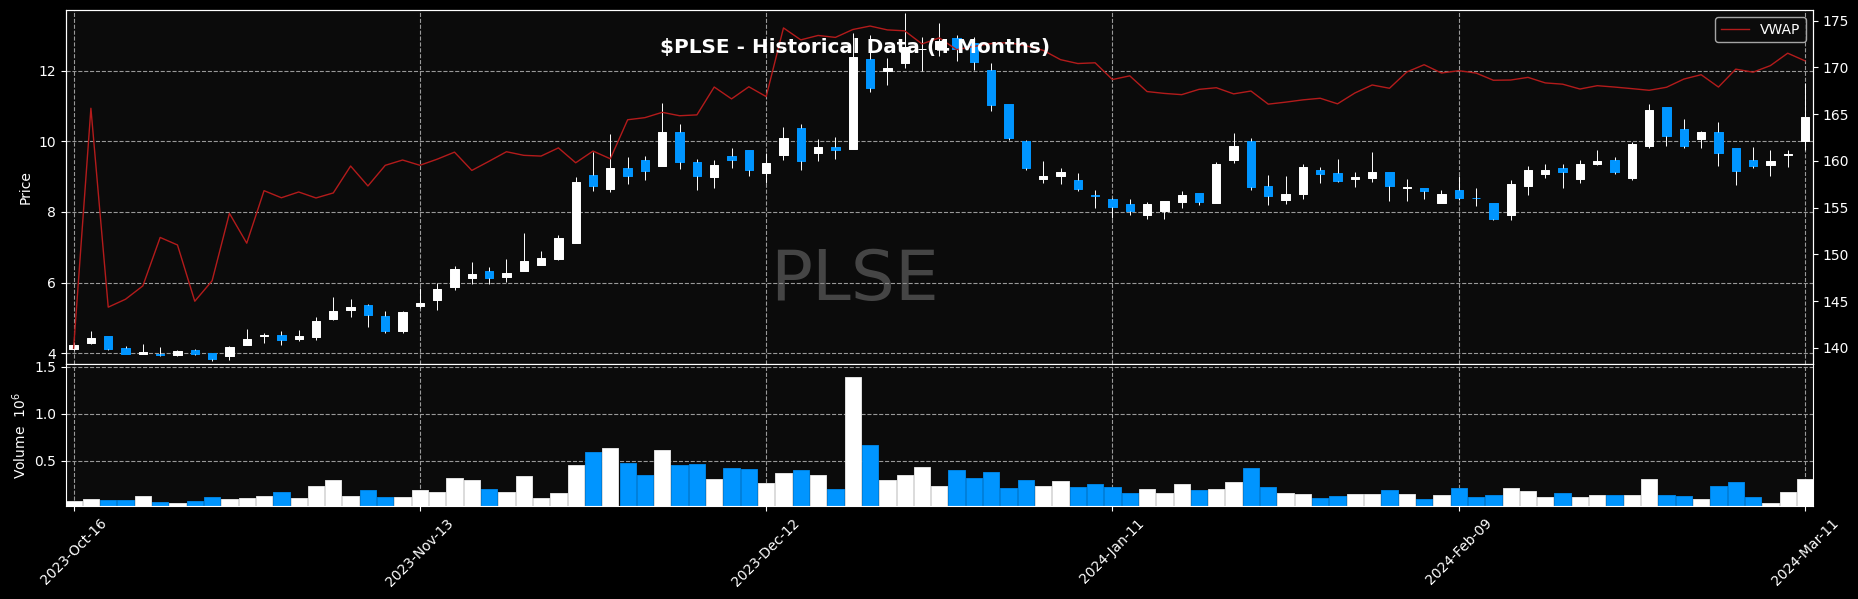

In [543]:
#### EXECUTE CHARTING ####
# DEV
plot_symbol_technicals(chart_historical_df, 'PLSE')

# # PRO
# for unique in unique_symbols:
#     plot_symbol_technicals(chart_historical_df, unique)

In [ ]:
"""
TREND LINE ALGORITHM
"""

'\nTREND LINE ALGORITHM\n'

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)